# Test of Bayesian Markov-Chain Monte-Carlo Method with ARCS Data

This data was supplied by Garrett Granroth from the SNS / Oak Ridge National Laboratory.

The data reduction was done in Mantid, preserving events, and the events are imported from a nexus autoreduced file.  
As such, the events do have some histogram artefacts from the way that the weights are computed.
I'm not sure if this can be entirely avoided with pixelated detectors, but in an ideal world we'd compute the event weighting factors without using histograms at all.

/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5


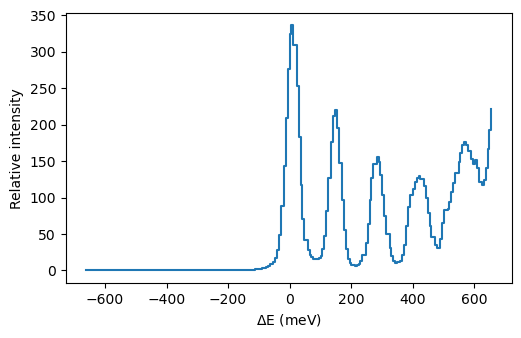

In [12]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

# Uncomment the following to make random things reproducable
# (useful for paper figures etc)

RANDOM_SEED = 0
np.random.seed(seed=RANDOM_SEED)

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, importlib lets us change the source and force reload of the emtk package.
# However, whilst the error reporting line number is right, the printout of
# the offending source code is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

#ema1.plot_histogram(loglog=False, log=False, xlabel='meV')

# Manually replot and save figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.savefig('arcsFigs/arcs_data_histo.png', bbox_inches='tight')
plt.show()


Least squares model function defined.
['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


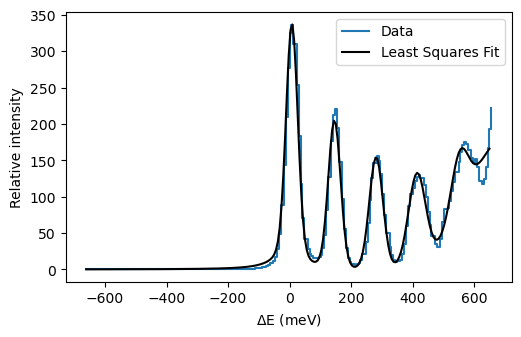

In [13]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
#ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_errors()
print(psigs)

detailed_fit_sigmas = psigs

# Manually replot and save figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post', label='Data')
nhy = hy.size
shy = np.sum(hy)
nly = ema1.lse_result.best_fit.size
sly = np.sum(ema1.lse_result.best_fit)

scl = shy * nly / (nhy * sly)

ax.plot(ema1.histx, scl*ema1.lse_result.best_fit, color='black', label='Least Squares Fit')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.legend()
plt.savefig('arcsFigs/arcs_data_lse.png', bbox_inches='tight')
plt.show()


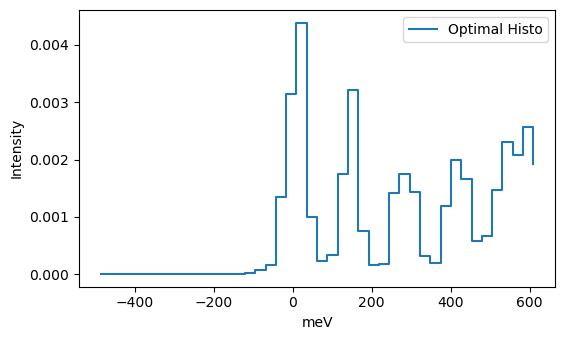

Calculating KDE
   - linear scale
nx 43
slice size 2.6090909090909093


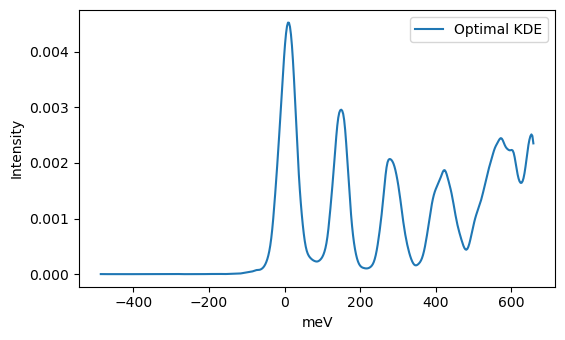

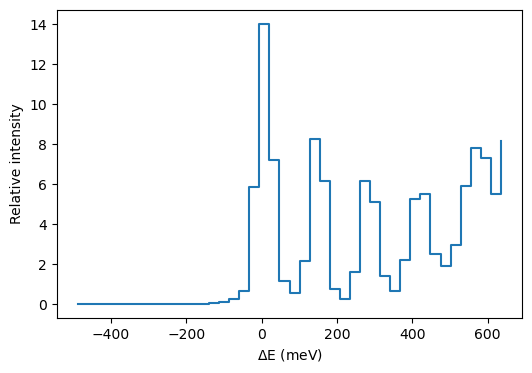

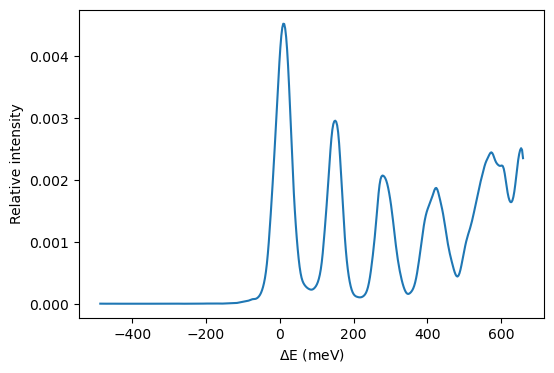

In [14]:
cpo = ema1.subsample(30000)
cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
cpo.plot_kde(loglog=False,log=False, xlabel='meV', method='fdr')

# Manually replot and save figure for a paper
bn=cpo.optimal_n_bins()
hst = np.histogram(cpo.data, bins=bn, weights=cpo.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_histo.png', bbox_inches='tight')
plt.show()

fig,ax=plt.subplots()
plt.plot(cpo.kdex, cpo.kdey)
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde.png', bbox_inches='tight')
plt.show()

In [15]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 + m4 + mbg1 + mbg2 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    raiseError = False
    result = 0.0

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    # Guard against zero values in each term
    minval = 1.0E-300

    msk = el < minval
    el[msk] = minval

    msk = l1 < minval
    l1[msk] = minval

    msk = l2 < minval
    l2[msk] = minval

    msk = l3 < minval
    l3[msk] = minval

    msk = l4 < minval
    l4[msk] = minval

    msk = bg1 < minval
    bg1[msk] = minval

    msk = bg2 < minval
    bg2[msk] = minval

    
 #   try:
    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        verbose=True
                    
    if verbose==True:
        print("lp", lp)
        print("lll", lll)
        print("l1", l1)
        print("l2", l2)
        print("l3", l3)
        print("l4", l4)
        print("bg1", bg1)
        print("bg2", bg2)
        print("")
        print("m0", mvals[0])
        print("m1", mvals[1])
        print("m2", mvals[2])
        print("m3", mvals[3])
        print("m4", mvals[4])
        print("m5", mvals[5])
        print("m6", mvals[6])

    return result

    
#   except RuntimeWarning as e:
#        print("Runtime warning at", theta)
#        print(e)
#        raise
    


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
# ema1.make_lse_params(
#    amplitude=dict(value=1.0, min=0.0),\
#    elmu = dict(value=10.0, min=-100.0, max=100.0),\
#    mu1 = dict(value=150.0, min=100.0, max=200.0),\
#    mu2 = dict(value=280.0, min=200.0, max=350.0),\
#    mu3 = dict(value=420.0, min=350.0, max=450.0),\
#    mu4 = dict(value=560.0, min=500.0, max=620.0),\
#    mubg1=dict(value=620.0, min=600.0, max=700.0),\
#    mubg2=dict(value=140.0, min=0.0, max=200.0),\

#    elsigma = dict(value=20.0, min=10.0, max=100.0),\
#    s1 = dict(value=30.0, min=10.0, max=100.0),\
#    s2 = dict(value=30.0, min=10.0, max=100.0),\
#    s3 = dict(value=30.0, min=10.0, max=100.0),\
#    s4 = dict(value=30.0, min=10.0, max=100.0),\
#    sbg1=dict(value=100.0, min=100.0, max=250.0),\
#    sbg2=dict(value=20.0, min=10.0, max=250.0),\
#    m1=dict(value=0.3, min=0.0, max = 1.0),\
#    m2=dict(value=0.2, min=0.0, max = 1.0),\
#    m3=dict(value=0.15, min=0.0, max = 1.0),\
#    m4=dict(value=0.1, min=0.0, max = 1.0),\
#    mbg1=dict(value=0.1, min=0.0, max=1.0),\
#    mbg2=dict(value=0.1, min=0.0, max=1.0)
#)

same_as_least_squares = np.array([10.0, 150.0, 280.0, 420.0, 560.0,\
                                 620.0, 140.0, 20.0, 30.0, 30.0,\
                                 30.0, 30.0, 100.0, 20.0,\
                                 0.3, 0.2, 0.15, 0.1, 0.1, 0.1])

#cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
# 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
# 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
# 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
# 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
# 2.74781599e-01])

nan_location = np.array([9.99999112e+00, 1.49999991e+02, 2.80000003e+02, 4.20000001e+02,\
 5.60000002e+02, 6.20000016e+02, 1.39999999e+02, 2.00000157e+01,\
 2.99999882e+01, 3.00000001e+01, 3.00000015e+01, 3.00000010e+01,\
 1.00000001e+02, 2.00000099e+01, 2.99987259e-01, 2.00008231e-01,\
 1.50005576e-01, 1.00000433e-01, 1.00000804e-01, 1.00002444e-01])

cpo.theta_seed = same_as_least_squares

# Seed MCMC search with LSE fit
#cpo.lse_fit()
#cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
#cpo.theta_seed = cpo.theta_seed[1:]

#log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False)
#test=log_likelihood_function(nan_location, ema1.data, np.amin(ema1.data), np.amax(ema1.data), ema1.weights, log_prior_function, verbose=True)

cpo.nwalkers=32 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 

cpo.MCMC_fit(nburn=150, niter=150) # fixed number of iterations
#cpo.MCMC_fit(niter=5000, convergence="Gelman-Rubin") # gelman-rubin method to check for convergence


MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:21<00:00,  6.87it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:23<00:00,  6.48it/s]

MCMC sampling complete.


In [32]:
cpo.gelman_rubin_statistic()

array([2.74993953, 2.71647178, 2.86841018, 2.84391453, 2.89004276,
       2.83260115, 2.7784174 , 2.93154603, 2.9125364 , 2.79195677,
       2.84858672, 2.76362641, 2.92546697, 2.55955562, 2.91925523,
       2.83575524, 2.93335946, 2.88618052, 2.91620867, 2.72611495])

(150, 41, 20)
(150, 41, 20)


True

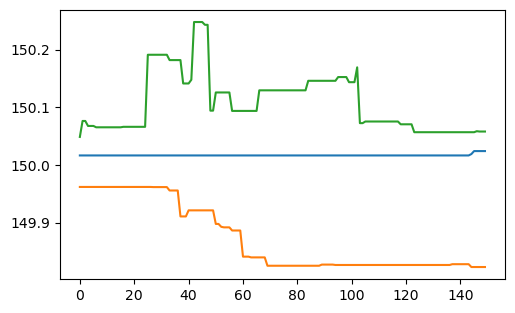

In [16]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-1000::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,1]
ch2 = burned[:,2,1]
ch3 = burned[:,3,1]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

cpo.self_check()

In [75]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(150, 41, 20)
mean shape (41, 20)
gmn  shape (20,)
wchv shape (41, 20)
w alt shape (41, 20)
bchv shape (20,)
[0.44617346 0.43565356 2.20759511 0.49742226 0.1836981  0.17167677
 0.20226873 1.3841977  0.43460031 0.45963769 0.80364517 0.68212959
 1.21974481 0.21229885 0.43662574 0.0930856  0.13493813 0.02315254
 0.10535257 0.08690463]
b alt shape (20,)
[0.00290194 0.00283352 0.01435834 0.00323527 0.00119478 0.0011166
 0.00131557 0.00900291 0.00282667 0.00298951 0.00522696 0.00443662
 0.0079333  0.00138081 0.00283984 0.00060543 0.00087765 0.00015059
 0.00068522 0.00056523]
ww shape (20,)
wwalt sh (20,)
ww [6.54972630e-04 6.06616664e-04 2.51345360e-03 7.75361227e-04
 1.95967523e-04 2.65179953e-04 3.29304751e-04 1.71700496e-03
 1.15119377e-03 6.16882016e-04 1.45604534e-03 9.68706325e-04
 1.50775691e-03 3.17488310e-04 4.46509840e-04 1.75091100e-04
 8.41189485e-05 3.43499611e-05 1.86782851e-04 8.04067125e-05]
wwalt [6.50606146e-04 6.02572553e-04 2.49669725e-03 7.70192152e-04
 1.94661073e-04 2.

In [35]:
  def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.6406006  1.59728066 1.62630331 1.66211819 1.65565043 1.64378481
 1.60383867 1.63936022 1.6276538  1.58198652 1.5799198  1.57843309
 1.63109449 1.51389016 1.62541059 1.6118803  1.69839771 1.59155379
 1.61456794 1.61582252]
[1.68570515 1.63938118 1.67590248 1.70996033 1.7051543  1.69113327
 1.65749305 1.68988225 1.67870269 1.62416211 1.63333273 1.62524171
 1.68706167 1.55601822 1.6774492  1.65926807 1.74745043 1.64731001
 1.66924354 1.67077303]
[1.81440621 1.77420571 1.86732925 1.8734791  1.88849889 1.85554682
 1.83280548 1.89801642 1.88842494 1.80437758 1.86018524 1.80908542
 1.91292846 1.727472   1.8932718  1.83743547 1.91235587 1.88291922
 1.8931132  1.82142031]
[1.88861993 1.89406526 1.91264609 1.91686778 1.93288684 1.91479616
 1.90843692 1.94862468 1.94321296 1.9078444  1.91456282 1.87334054
 1.94763936 1.80912939 1.94524567 1.92324283 1.95497267 1.92954694
 1.94504813 1.86492443]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1287/62179585.py:23: RuntimeWarning: invalid value encountered in divide
  t1 = (nsamps-1.0)*ww / nsamps


Calculating KDE
   - linear scale
nx 43
slice size 2.6090909090909093


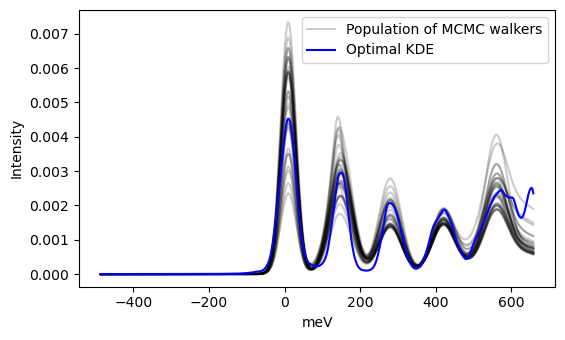

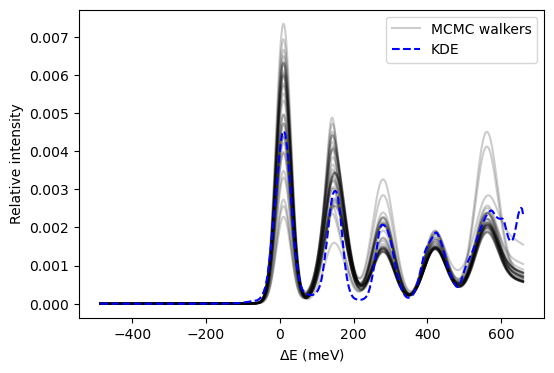

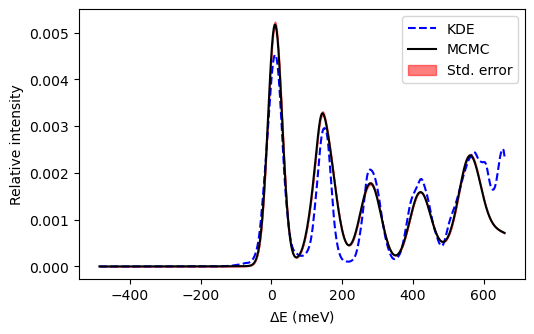

In [17]:
#cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

cpo.self_check()

cpo.plot_MCMC_fit(method='kde', loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method='histo', loglog=False, log=False, xlabel='meV')

# Repeat plot manually for paper output

flt = cpo.sampler.get_chain(discard=20, thin=15, flat=True)
inds  = np.random.choice(len(flt), size=30, replace=False)
pt_sum = np.sum(cpo.kdey)

fig,ax=plt.subplots()

for ind in inds:
    smp = flt[ind]
    yfit = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)
    ysum = np.sum(yfit)
    scale = pt_sum / ysum
    yfit = yfit * scale

    if ind == inds[0]:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2, label='MCMC walkers')
    else:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2)

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit.png', bbox_inches='tight')
plt.show()

# Plot showing the average of the PDFs over all walkers?
inds = np.arange(len(flt))

yfit = np.zeros((len(inds),cpo.kdex.size))

for ind in inds:
    smp = flt[ind]
    yfit[ind] = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)

ymean = np.mean(yfit, axis=0)
ystd = np.std(yfit, axis=0)
ystd = ystd / np.sqrt(len(inds))

                
ysum = np.sum(ymean)
scale = pt_sum / ysum
ymean = ymean * scale
ystd = ystd * scale

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.plot(cpo.kdex, ymean, color='black', label='MCMC')
plt.fill_between(cpo.kdex, ymean-ystd, ymean+ystd, color='red', alpha=0.5, label='Std. error')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit_mean.png', bbox_inches='tight')
plt.show()

stdd 0.06988249790601588
stdd 0.09378688027200917
stdd 0.1550918873444523
stdd 0.10005404556995368
stdd 0.044894411556846606
stdd 0.06527383375800289
stdd 0.0567567534629737
stdd 0.19835355772634883
stdd 0.09513658268111849
stdd 0.08339918346259875
stdd 0.13828631843430503
stdd 0.10442020149257744
stdd 0.1315584133836127
stdd 0.04602633028986856
stdd 0.06029521076669431
stdd 0.03392932310855464
stdd 0.035039492365699636
stdd 0.012422792817275423
stdd 0.039934190575478604
stdd 0.030185568532324084
149.9712647760447 +/- 0.001195926617045849 using method mean


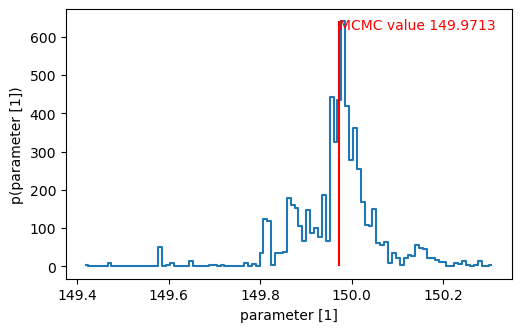

fwhm 1.5769760982828842
fwhm 5.022516431924885
fwhm 3.9189970250743755
fwhm 2.7589502288851193
fwhm 1.715539602868887
fwhm 3.2059364583189165
fwhm 4.276559719910459
fwhm 7.607308048103608
fwhm 6.22812118147727
fwhm 4.0463768115942
fwhm 4.470247046186898
fwhm 3.866757000903334
fwhm 2.1102681491170703
fwhm 3.0932318239795933
fwhm 2.2121905354181486
fwhm 3.2002013307471344
fwhm 3.5737268452954174
fwhm 1.4045454545454543
fwhm 1.5393639531989045
fwhm 1.259818731117825
149.98154457355844 +/- 0.037703489029568556 using method peak


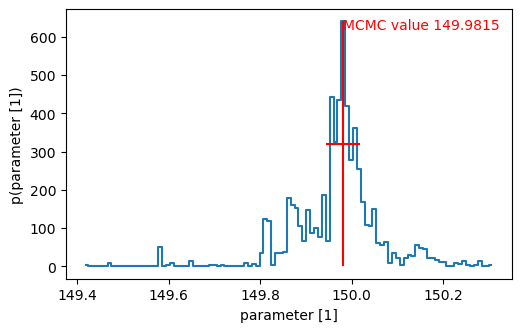

In [18]:
lookat=1
#cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='mean', savename='arcsFigs/arcs_parameter_mean.png')
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='peak', savename='arcsFigs/arcs_parameter_peak.png')


In [20]:
print("PEAK METHOD:")
mcpparams, mcperr = cpo.get_MCMC_parameters(method='peak')
print(mcpparams)
print(mcperr)

print()
print("MEAN METHOD:")
mcparams, mcerr = cpo.get_MCMC_parameters(method='mean')
print(mcparams)
print(mcerr)

print()
print("LSE on full data set")
lsparams = ema1.get_lse_param_values()


lserrors = ema1.get_lse_param_errors()
print(lsparams)
print(lserrors)

import pandas

pn = ema1.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": lsparams[1:], "LSE_ERR": lserrors[1:], "BAYES": mcparams, "BAYES_ERR": mcerr, "BAYES-PEAK": mcpparams, "BAYES-PEAK-ERR": mcperr})
print(df)

PEAK METHOD:
fwhm 1.5769760982828842
fwhm 5.022516431924885
fwhm 3.9189970250743755
fwhm 2.7589502288851193
fwhm 1.715539602868887
fwhm 3.2059364583189165
fwhm 4.276559719910459
fwhm 7.607308048103608
fwhm 6.22812118147727
fwhm 4.0463768115942
fwhm 4.470247046186898
fwhm 3.866757000903334
fwhm 2.1102681491170703
fwhm 3.0932318239795933
fwhm 2.2121905354181486
fwhm 3.2002013307471344
fwhm 3.5737268452954174
fwhm 1.4045454545454543
fwhm 1.5393639531989045
fwhm 1.259818731117825
[9.99764313e+00 1.49981545e+02 2.80000492e+02 4.19983508e+02
 5.59999827e+02 6.19997865e+02 1.39989386e+02 1.99950841e+01
 3.00095710e+01 2.99681080e+01 2.99877741e+01 2.99913746e+01
 1.00000004e+02 1.99962428e+01 2.98408945e-01 1.98550455e-01
 1.00017708e-01 1.00001195e-01 1.00000037e-01 1.00018580e-01]
[0.01183819 0.03770349 0.02941949 0.02071114 0.01287837 0.02406662
 0.03210367 0.05710724 0.04675383 0.03037571 0.03355766 0.02902733
 0.01584156 0.02322056 0.01660668 0.02402357 0.02682758 0.01054377
 0.01155584 

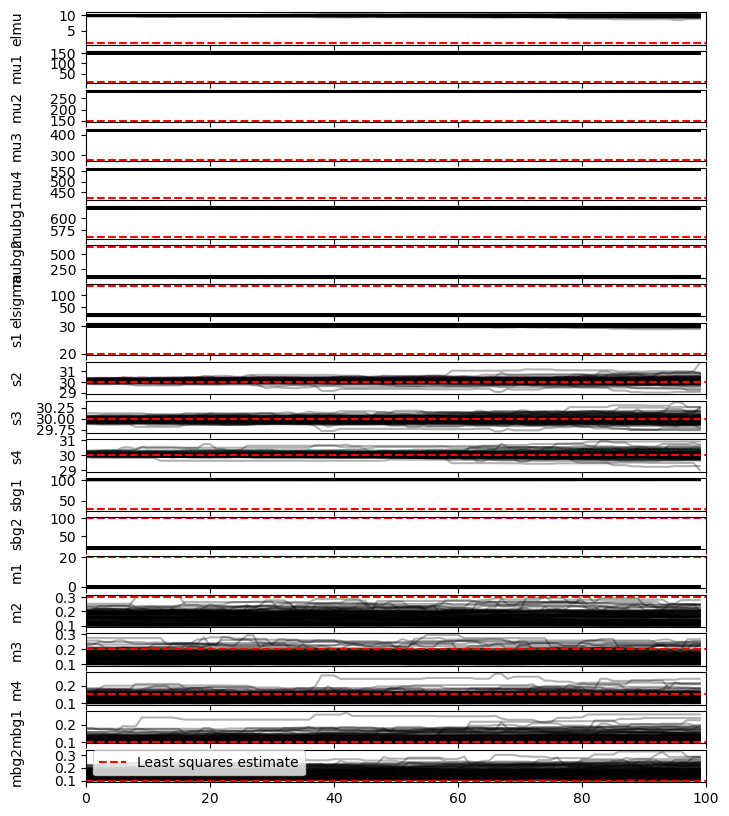

In [31]:
cpo.plot_MCMC_convergences()

## Event-dependent convergence study

In [21]:
assumed_param_values = np.copy(mcparams)

RANDOM_SEED = 1
np.random.seed(seed=RANDOM_SEED)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(2, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 10
lsMaxEvents = 10000000
mcmcMaxEvents = 90000


rep = 0

for nn in n_evs:
    print("Rep", rep+1, "/", evreps, "|", nn, "/", evs.size)
    print("Subsampling...")
    sse = ema1.subsample(nn)

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_errors()
    else:
        print("Skipping Least Squares Analysis (too few events for stable fit)")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = same_as_least_squares
        sse.MCMC_fit(nburn=150, niter=150)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters(method='mean')
    else:
        print("Skipping MCMC Analysis (too many events to run on a laptop in sensible time)")

    rep = rep + 1

print("Convergence loop complete.")

2623437
6.418870639382126
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623436]
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623437]
Rep 1 / 10 | 100 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


  0%|                                                   | 0/150 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.97it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 26.54it/s]


MCMC sampling complete.
stdd 0.10706301578470503
stdd 0.16317683846959383
stdd 0.1256133941764983
stdd 0.10745110509929555
stdd 0.1462814860581341
stdd 0.1382734290361712
stdd 0.10633868259714371
stdd 0.11546739184597699
stdd 0.18929465264460832
stdd 0.10164282114366692
stdd 0.17494025146807646
stdd 0.13688882839520883
stdd 0.07515901199968594
stdd 0.1544815017632844
stdd 0.08049629813190912
stdd 0.04399729383108323
stdd 0.03584959262587092
stdd 0.03722341183801605
stdd 0.026293973222138844
stdd 0.019501050503385586
Rep 2 / 10 | 309 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 23.80it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.77it/s]


MCMC sampling complete.
stdd 0.08693367030208396
stdd 0.09917361419685801
stdd 0.08583468387655607
stdd 0.09018116848494039
stdd 0.07593209015007182
stdd 0.08832327675102032
stdd 0.06554317349555325
stdd 0.07596182705744471
stdd 0.12496659430289155
stdd 0.07027258585936336
stdd 0.08565125132220885
stdd 0.06534732291939686
stdd 0.03788163265157393
stdd 0.10033561476551277
stdd 0.06552863020452514
stdd 0.047769143473175964
stdd 0.04134893673436191
stdd 0.023539121170156677
stdd 0.031106043236887943
stdd 0.045315553481098454
Rep 3 / 10 | 959 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 19.46it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 20.59it/s]


MCMC sampling complete.
stdd 0.053025112006073676
stdd 0.07497758409928267
stdd 0.12393115247465411
stdd 0.08356276677924987
stdd 0.09946823407272222
stdd 0.05844177044667661
stdd 0.0728292709157861
stdd 0.07473649515909696
stdd 0.12571695229811705
stdd 0.06582502718654923
stdd 0.07344786222564535
stdd 0.10044122301416536
stdd 0.04828467364153856
stdd 0.10729418828312812
stdd 0.08093857056772348
stdd 0.05323978589823736
stdd 0.033332747334236044
stdd 0.026570000523159176
stdd 0.021987207213680558
stdd 0.03194328967899353
Rep 4 / 10 | 2971 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 13.22it/s]


MCMC sampling complete.
stdd 0.15160544647643354
stdd 0.08394525142561883
stdd 0.0832015462158663
stdd 0.058679584966118505
stdd 0.10475426633011702
stdd 0.1366801403788251
stdd 0.10718567667898093
stdd 0.12015252089597411
stdd 0.06352699616604121
stdd 0.10215429509844924
stdd 0.10346830335681675
stdd 0.12269974481823258
stdd 0.035987665097439905
stdd 0.1092199648006647
stdd 0.0812691184892983
stdd 0.04411531260953306
stdd 0.06316687800352563
stdd 0.03942360623644311
stdd 0.02768893337508283
stdd 0.02816411088316342
Rep 5 / 10 | 9203 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:24<00:00,  6.05it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:24<00:00,  6.12it/s]


MCMC sampling complete.
stdd 0.10613049120600695
stdd 0.10181168084533572
stdd 0.10179288266758547
stdd 0.08562485467291263
stdd 0.133923151632956
stdd 0.09706732563708793
stdd 0.15258124965348852
stdd 0.08329000833989088
stdd 0.12260496703688112
stdd 0.11720562462568353
stdd 0.12154640733578548
stdd 0.10619539541904971
stdd 0.038647164439865586
stdd 0.0764742129383279
stdd 0.06803865273368243
stdd 0.04804837406268652
stdd 0.04338083885492949
stdd 0.04457072075991778
stdd 0.015672690874134934
stdd 0.038763079150691465
Rep 6 / 10 | 28505 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [01:08<00:00,  2.19it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [01:06<00:00,  2.26it/s]


MCMC sampling complete.
stdd 0.10361268812166442
stdd 0.061783776790962336
stdd 0.14984260055983598
stdd 0.1287231202511054
stdd 0.14965130459276368
stdd 0.11435680444728137
stdd 0.15245471319167125
stdd 0.12311280880750937
stdd 0.14908167010051665
stdd 0.2106321968704882
stdd 0.12366412080319959
stdd 0.11398637214279203
stdd 0.04419094380693408
stdd 0.10165473461412046
stdd 0.06439760767861416
stdd 0.051238822848259445
stdd 0.03548678472928898
stdd 0.026936970514103837
stdd 0.02430072209527202
stdd 0.06614842673693432
Rep 7 / 10 | 88290 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [03:19<00:00,  1.33s/it]


Sampling:


100%|█████████████████████████████████████████| 150/150 [03:34<00:00,  1.43s/it]


MCMC sampling complete.
stdd 0.30519375611637367
stdd 0.41765645290661146
stdd 0.6681169757246344
stdd 0.38175091586439247
stdd 0.42135477024410584
stdd 0.7155266029288498
stdd 0.34689524111994935
stdd 0.31781999118377435
stdd 0.6339640621507954
stdd 0.8461861166556104
stdd 0.46699427477515837
stdd 0.28846782878257543
stdd 0.09964132015779133
stdd 0.2284713594541166
stdd 0.04051443570148535
stdd 0.03759259349393036
stdd 0.027987797420998977
stdd 0.034125589387645705
stdd 0.03151678319279814
stdd 0.02693695016154918
Rep 8 / 10 | 273463 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 9 / 10 | 847003 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 10 / 10 | 2623437 / 2623437
Subsampling...
Subsample will return a direct copy of the data instead.
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a l

In [198]:
def p_conv_plot(item, param_name='', Bayes=True, LSE=True, savename='', correct=np.inf, ylims=[np.inf, np.inf]):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    if LSE:
        ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
        ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE std. err')
        ax.set_ylim([wbot, wtop])
        ax.set_xlabel("# events")
        ax.set_ylabel(pnam + "Value")
        if param_name != '':
            ax.set_ylabel(param_name)

    if Bayes:
        ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
        ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes std. err')

    if np.isfinite(correct):
        xmin=np.amin(mcnevs)
        xmax=np.amax(lsnevs)
        plt.hlines(correct, xmin, xmax, label='Visual estimate', ls='--', color='orange')


    if np.isfinite(ylims).all():
        plt.ylim(ylims)
    
    
    plt.xscale('log')
    plt.yscale('linear')
    ax.legend()

        

    if savename != '':
        plt.savefig(savename, bbox_inches='tight')
        plt.show()
    
    #print(sse.get_lse_param_names())

    

### Elastic Line Parameters

What are the correct values?  lets inspect the kde of the full data set.

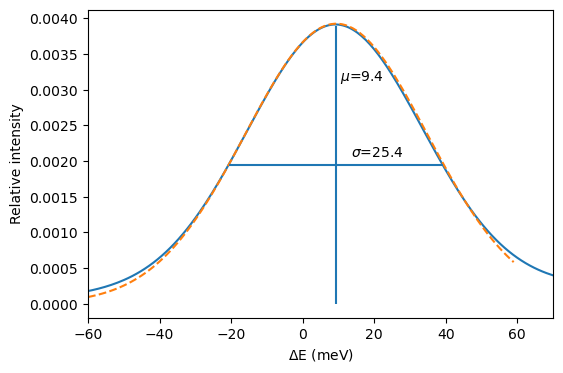

In [205]:
#ema1.plot_kde(loglog=False,log=False, xlabel='meV', method='silverman')

mu=9.4
sig=25.4
norm=4.0
ht=0.0039

px=np.arange(-60,60,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([-60,70])
plt.savefig('arcsFigs/arcs_fulldata_kde_elastic.png', bbox_inches='tight')
plt.show()

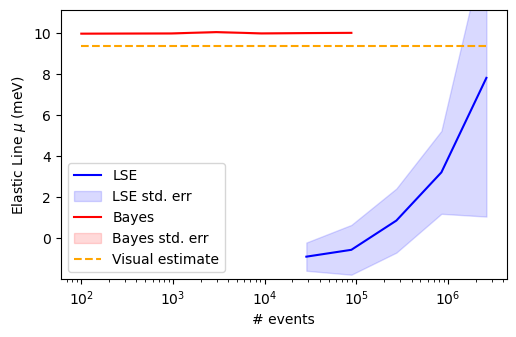

In [199]:
parameter_no = 0
p_conv_plot(parameter_no, param_name='Elastic Line $\mu$ (meV)', savename='arcsFigs/arcs_elastic_mu.png', correct=9.4)
#p_conv_plot(parameter_no, LSE=False)

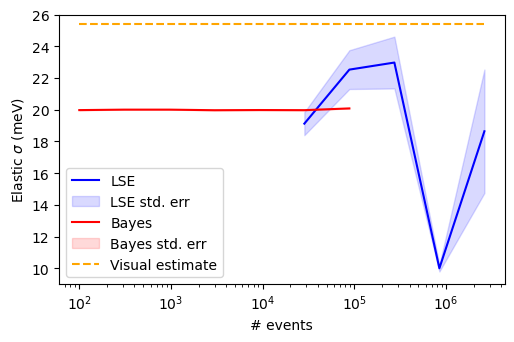

In [200]:
parameter_no = 7
p_conv_plot(parameter_no, param_name='Elastic $\sigma$ (meV)', savename='arcsFigs/arcs_elastic_sigma.png', correct=25.4, ylims=[9, 26])
#p_conv_plot(parameter_no, LSE=False)

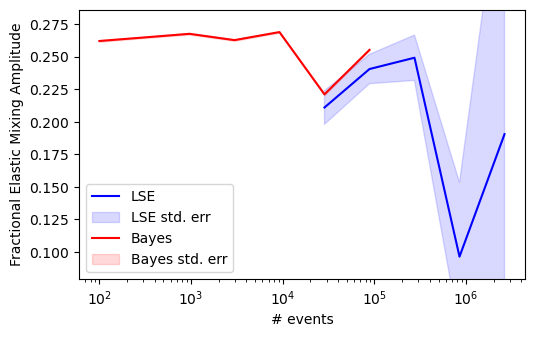

In [25]:
parameter_no = 14
p_conv_plot(parameter_no, param_name='Fractional Elastic Mixing Amplitude', savename='arcsFigs/arcs_elastic_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Excitation Line Parameters

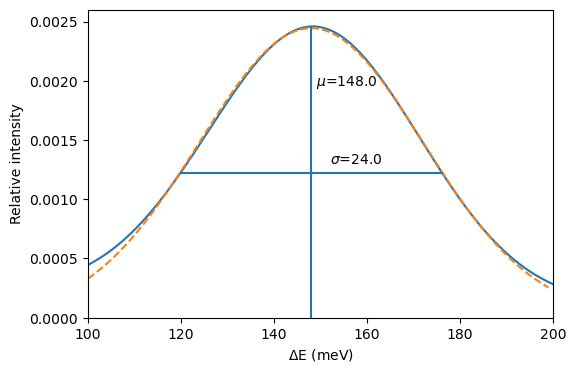

In [206]:
mu=148.0
sig=24.0
norm=6.8
ht=0.00245

px=np.arange(100,200,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([100,200])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex1.png', bbox_inches='tight')
plt.show()

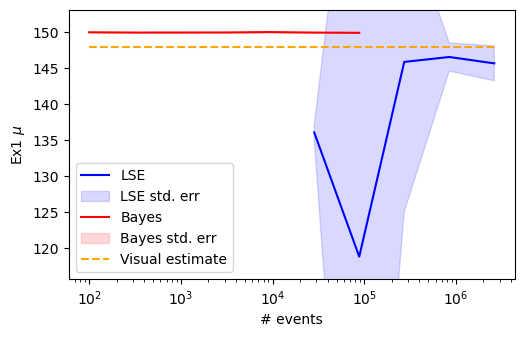

In [190]:
parameter_no = 1
p_conv_plot(parameter_no, param_name='Ex1 $\mu$', savename='arcsFigs/arcs_ex1_mu.png', correct=148.0)
#p_conv_plot(parameter_no, LSE=False)

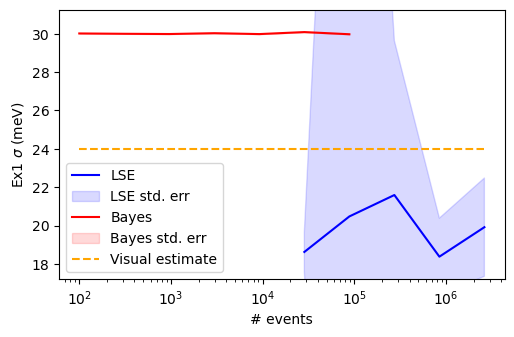

In [191]:
parameter_no = 8
p_conv_plot(parameter_no, param_name='Ex1 $\sigma$ (meV)', savename='arcsFigs/arcs_ex1_sigma.png', correct=24)
#p_conv_plot(parameter_no, LSE=False)

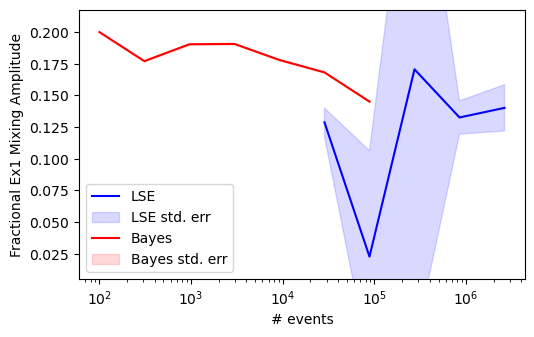

In [30]:
parameter_no = 15
p_conv_plot(parameter_no, param_name='Fractional Ex1 Mixing Amplitude', savename='arcsFigs/arcs_ex1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Excitation Line Parameters

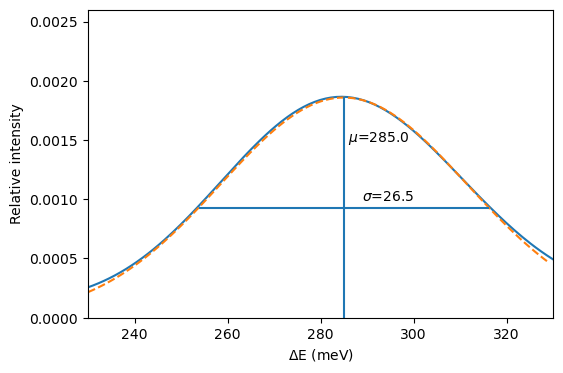

In [207]:
mu=285.0
sig=26.5
norm=8.1
ht=0.00186

r1=230
r2=330

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex2.png', bbox_inches='tight')
plt.show()

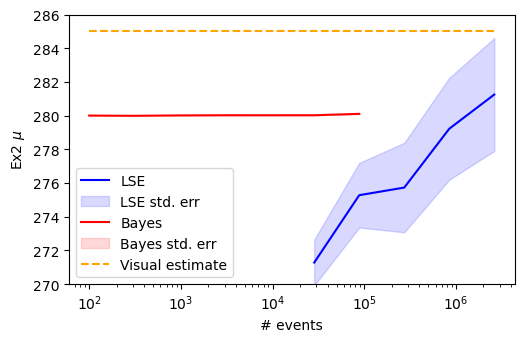

In [202]:
parameter_no = 2
p_conv_plot(parameter_no, param_name='Ex2 $\mu$', savename='arcsFigs/arcs_ex2_mu.png', correct=285.0, ylims=[270, 286])
#p_conv_plot(parameter_no, LSE=False)

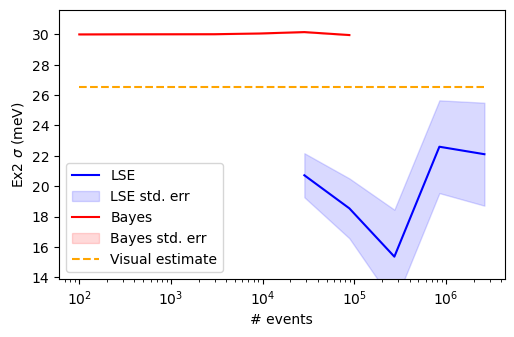

In [194]:
parameter_no = 9
p_conv_plot(parameter_no, param_name='Ex2 $\sigma$ (meV)', savename='arcsFigs/arcs_ex2_sigma.png', correct=26.5)
#p_conv_plot(parameter_no, LSE=False)

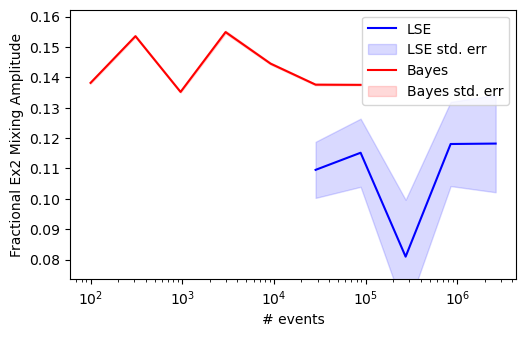

In [33]:
parameter_no = 16
p_conv_plot(parameter_no, param_name='Fractional Ex2 Mixing Amplitude', savename='arcsFigs/arcs_ex2_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Third Excitation Line Parameters

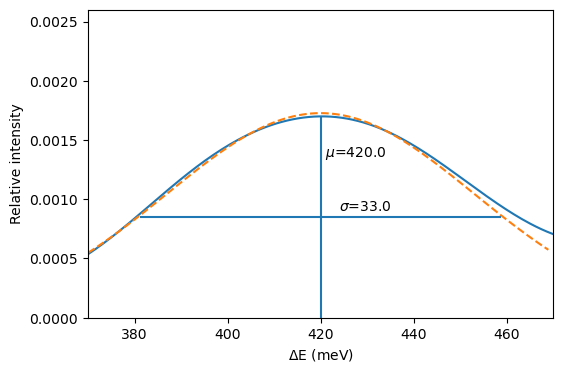

In [208]:
window_mu=420.0
mu=420.0
sig=33.0
norm=7.0
ht=0.0017

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex3.png', bbox_inches='tight')
plt.show()

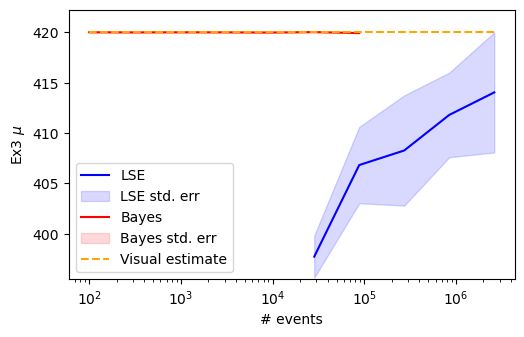

In [195]:
parameter_no = 3
p_conv_plot(parameter_no, param_name='Ex3 $\mu$', savename='arcsFigs/arcs_ex3_mu.png', correct=420.0)
#p_conv_plot(parameter_no, LSE=False)

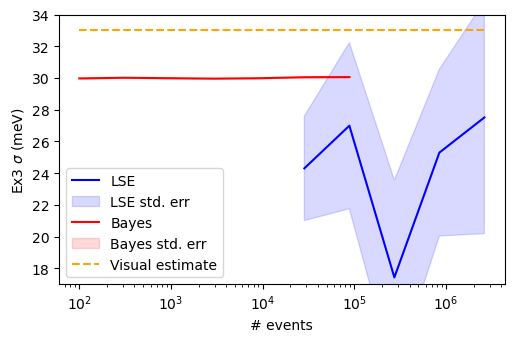

In [203]:
parameter_no = 10
p_conv_plot(parameter_no, param_name='Ex3 $\sigma$ (meV)', savename='arcsFigs/arcs_ex3_sigma.png', correct=33.0, ylims=[17, 34])
#p_conv_plot(parameter_no, LSE=False)

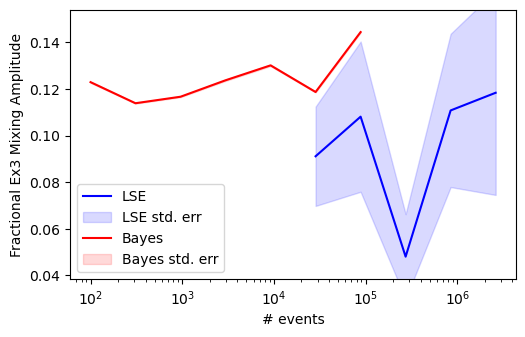

In [36]:
parameter_no = 17
p_conv_plot(parameter_no, param_name='Fractional Ex3 Mixing Amplitude', savename='arcsFigs/arcs_ex3_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Fourth Excitation Line Parameters

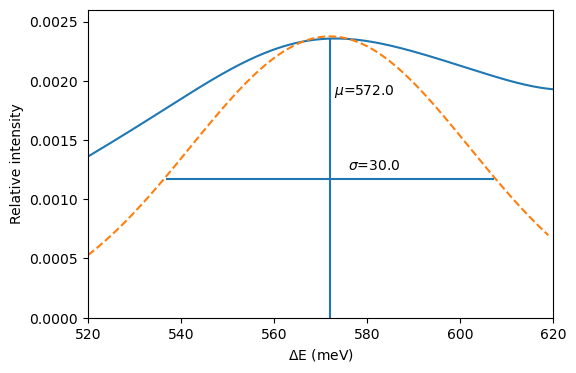

In [209]:
window_mu=570.0
mu=window_mu+2
sig=30.0
norm=5.6
ht=0.00235

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex4.png', bbox_inches='tight')
plt.show()

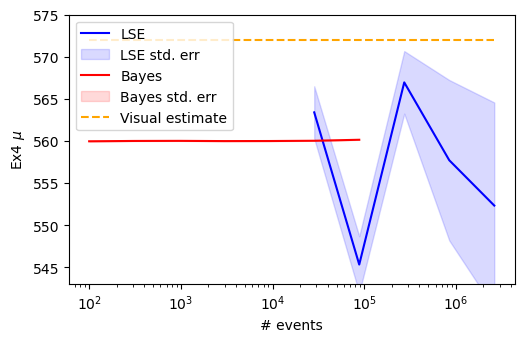

In [204]:
parameter_no = 4
p_conv_plot(parameter_no, param_name='Ex4 $\mu$', savename='arcsFigs/arcs_ex4_mu.png', correct=572.0, ylims=[543, 575])
#p_conv_plot(parameter_no, LSE=False)

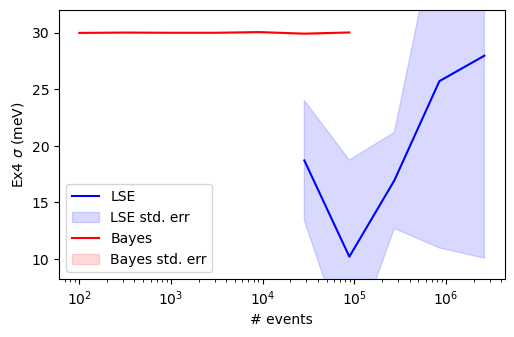

In [38]:
parameter_no = 11
p_conv_plot(parameter_no, param_name='Ex4 $\sigma$ (meV)', savename='arcsFigs/arcs_ex4_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

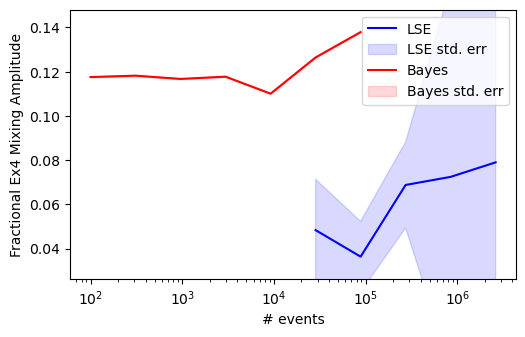

In [39]:
parameter_no = 18
p_conv_plot(parameter_no, param_name='Fractional Ex4 Mixing Amplitude', savename='arcsFigs/arcs_ex4_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Background Term Parameters 

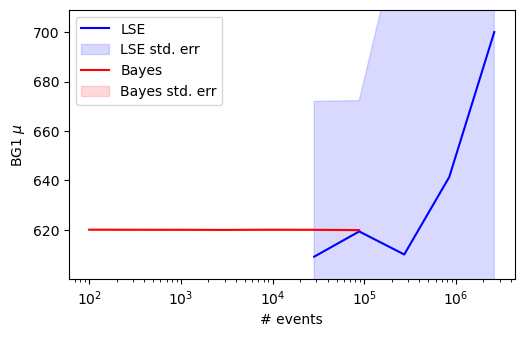

In [210]:
parameter_no = 5
p_conv_plot(parameter_no, param_name='BG1 $\mu$', savename='arcsFigs/arcs_BG1_mu.png')
#p_conv_plot(parameter_no, LSE=False)

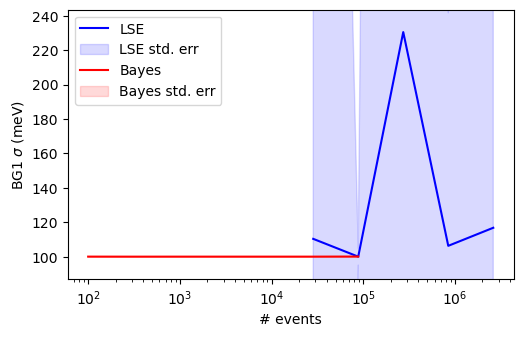

In [211]:
parameter_no = 12
p_conv_plot(parameter_no, param_name='BG1 $\sigma$ (meV)', savename='arcsFigs/arcs_BG1_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

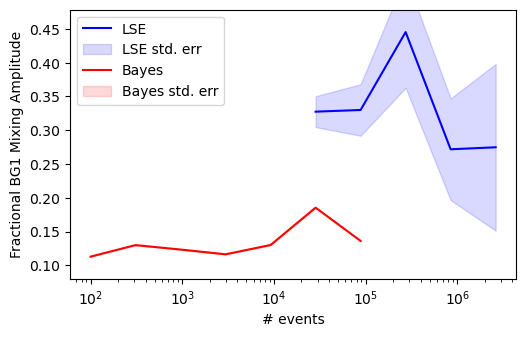

In [212]:
parameter_no = 19
p_conv_plot(parameter_no, param_name='Fractional BG1 Mixing Amplitude', savename='arcsFigs/arcs_BG1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Background Term Parameters

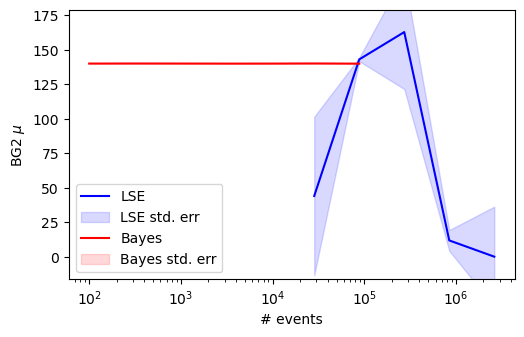

In [44]:
parameter_no = 6
p_conv_plot(parameter_no, param_name='BG2 $\mu$', savename='arcsFigs/arcs_BG2_mu.png')
#p_conv_plot(parameter_no, LSE=False)

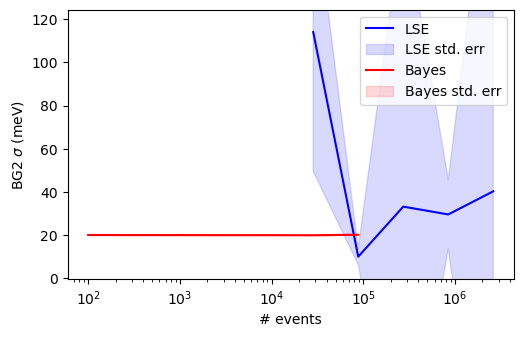

In [45]:
parameter_no = 13
p_conv_plot(parameter_no, param_name='BG2 $\sigma$ (meV)', savename='arcsFigs/arcs_BG2_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

The weight of the second background term is computed from 1-sum(other_weights) so it has no individual parameter.

## Important Questions and Possible Answers

1. Why does the parameter noise obviously exceed the reported variance for the MCMC parameters?

Probably because the random subsample of events is at each step random.  The variance is the *statistical* variance as sampled by MCMC within the data set, whilst the subsampling of the events for low numbers of events provides a systematic shift of that parameter space from analysis to analysis.  The correct variance would probably be obtained by re-subsampling many times and computing the mean and standard error of the obtained parameters.  This is going to be very slow and would require a cluster job in the future to do that work.

2. Why does the variance on some LSE parameters increase with increasing events?

Probably because the LSE is unstable with so many parameters, and it is getting stuck in a local optimum.  If you look at some of the parameters the stated variances for these parameters are enormous, so the LSE estimates from the chi-squared surface curvature are probably wrong.  Since many of the parameter values are so close to those obtained from MCMC I suspect that monte-carlo sampling the LSE parameter space as described above might yield more realistic parameter variances.
